# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [75]:
import numpy as np
import pandas as pd
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [77]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [78]:
# Compute daily volatility
vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

Calculating daily volatility for dynamic thresholds


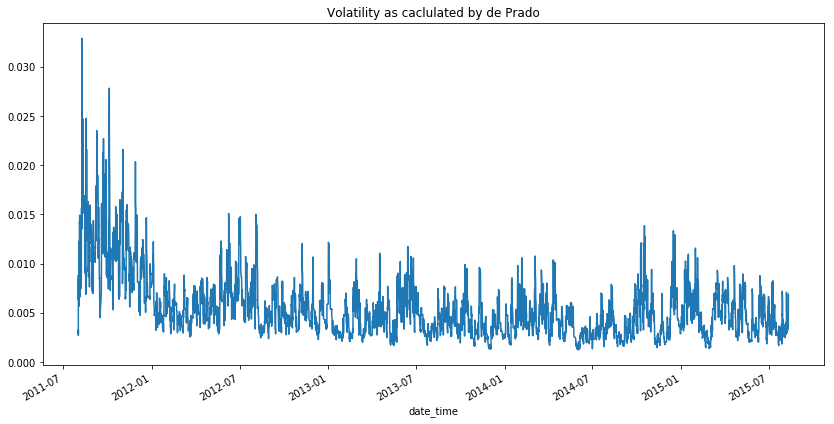

In [79]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [80]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=vol.mean())

  1%|▏         | 592/39998 [00:00<00:06, 5912.41it/s]

Applying Symmetric CUSUM filter.


100%|██████████| 39998/39998 [00:06<00:00, 6574.17it/s]


**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [81]:
# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 10:51:41.842   2011-08-02 10:52:48.191
2011-08-01 13:36:46.215   2011-08-02 13:37:28.849
2011-08-01 14:00:21.448   2011-08-02 14:04:29.869
2011-08-01 14:03:22.782   2011-08-02 14:04:29.869
2011-08-01 14:21:49.179   2011-08-02 14:27:55.423
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [82]:
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=[1, 1],
                                  target=vol,
                                  min_ret=0.01,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=None)

/home/ariadne/Desktop/Research Project/research/2019-03-03_AS_JJ_Chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [83]:
triple_barrier_events.head()

,t1,trgt
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011841
2011-08-04 09:08:28.542,2011-08-04 12:43:40.327,0.012108
2011-08-04 10:27:24.326,2011-08-04 14:58:04.748,0.011682
2011-08-04 12:29:39.619,2011-08-04 15:01:19.020,0.011022
2011-08-04 19:44:06.743,2011-08-05 13:54:12.782,0.011423


In [84]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

In [85]:
labels.head()

,ret,trgt,bin
2011-08-04 01:57:00.466,-0.016254,0.011841,-1
2011-08-04 09:08:28.542,-0.012762,0.012108,-1
2011-08-04 10:27:24.326,-0.011686,0.011682,-1
2011-08-04 12:29:39.619,-0.011907,0.011022,-1
2011-08-04 19:44:06.743,-0.012887,0.011423,-1


In [86]:
labels['bin'].value_counts()

 1    255
-1    207
 0    198
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [87]:
clean_labels = CoreFunctions.drop_labels(labels)

In [88]:
print(labels.shape)
print(clean_labels.shape)

(660, 3)
(660, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

First, Build a simple moving average crossover strateggy

In [89]:
close_prices = data['close']
print(len(close_prices))
close_prices.head()

40000


date_time
2011-07-31 23:31:58.810    1305.75
2011-08-01 02:55:17.443    1306.50
2011-08-01 07:25:56.319    1305.00
2011-08-01 08:33:10.903    1300.00
2011-08-01 10:51:41.842    1307.75
Name: close, dtype: float64

Define the window size for crossover lines

In [90]:
fast_window = 20
slow_window = 50

Create a data frame with the close prices and the rolling moving averages

In [91]:
signal_df = close_prices.to_frame()
signal_df['fast_ma'] = signal_df['close'].rolling(window=fast_window, min_periods=1, center=False).mean()
signal_df['slow_ma'] = signal_df['close'].rolling(window=slow_window, min_periods=1, center=False).mean()
signal_df['side'] = 0.0
signal_df.head()


,close,fast_ma,slow_ma,side
date_time,,,,
2011-07-31 23:31:58.810,1305.75,1305.7500,1305.7500,0.0
2011-08-01 02:55:17.443,1306.50,1306.1250,1306.1250,0.0
2011-08-01 07:25:56.319,1305.00,1305.7500,1305.7500,0.0
2011-08-01 08:33:10.903,1300.00,1304.3125,1304.3125,0.0
2011-08-01 10:51:41.842,1307.75,1305.0000,1305.0000,0.0


Create a side when the short MA crosses over the long MA. Ensure that this is done for the period that is larger than the shortest MA window


In [92]:
# compute sides
signal_df['side'][fast_window:] = np.where(signal_df['fast_ma'][fast_window:] >= 
                                           signal_df['slow_ma'][fast_window:], 1.0, -1.0) 

print(signal_df.side.value_counts())

 1.0    21568
-1.0    18412
 0.0       20
Name: side, dtype: int64


The few 0.0 labels are a result of NaNs

In [93]:
print(signal_df.head())
print(signal_df.tail())

                           close    fast_ma    slow_ma  side
date_time                                                   
2011-07-31 23:31:58.810  1305.75  1305.7500  1305.7500   0.0
2011-08-01 02:55:17.443  1306.50  1306.1250  1306.1250   0.0
2011-08-01 07:25:56.319  1305.00  1305.7500  1305.7500   0.0
2011-08-01 08:33:10.903  1300.00  1304.3125  1304.3125   0.0
2011-08-01 10:51:41.842  1307.75  1305.0000  1305.0000   0.0
                           close    fast_ma   slow_ma  side
date_time                                                  
2015-08-10 13:40:00.351  2090.00  2076.5250  2072.420   1.0
2015-08-10 13:44:10.435  2092.25  2077.8250  2072.645   1.0
2015-08-10 13:49:44.719  2092.50  2079.0875  2072.995   1.0
2015-08-10 13:53:25.555  2093.00  2080.4625  2073.380   1.0
2015-08-10 14:00:07.700  2093.25  2081.6625  2073.800   1.0


In [94]:
# extract side as a series
side = signal_df['side']

On those sampled features, apply the triple-barrier method, where ptSl=[1,2] and t1 earlier

In [120]:
ma_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[1, 2],
                                     target=vol,
                                     min_ret=0.007,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


In [121]:
print(ma_events.head())
print('')
print(ma_events.side.value_counts())

                         side                      t1      trgt
2011-08-02 15:02:12.277  -1.0 2011-08-02 17:57:51.964  0.008616
2011-08-02 16:48:53.474  -1.0 2011-08-02 19:52:57.011  0.007736
2011-08-03 01:53:52.265  -1.0 2011-08-03 14:37:04.871  0.008415
2011-08-03 08:02:36.120  -1.0 2011-08-03 14:23:36.205  0.008016
2011-08-03 14:56:24.514  -1.0 2011-08-04 01:57:00.466  0.007678

-1.0    605
 1.0    576
Name: side, dtype: int64


In [122]:
labels = CoreFunctions.get_bins(ma_events, close_prices)

In [123]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-02 15:02:12.277  0.009338  0.008616    1
2011-08-02 16:48:53.474  0.008583  0.007736    1
2011-08-03 01:53:52.265  0.010746  0.008415    1
2011-08-03 08:02:36.120  0.010473  0.008016    1
2011-08-03 14:56:24.514 -0.017443  0.007678    0


0    699
1    482
Name: bin, dtype: int64

In [135]:
# Save trade data
new_data = pd.concat([labels, ma_events], axis=1)
new_data.columns = ['return', 'trgt', 'trade', 'side', 'first_touch', 'trgt2']
new_data.drop('trgt2', axis=1, inplace=True)

# Save files to csv
new_data.to_csv('ma_side.csv')
close_prices.to_csv('ma_close_prices.csv', header=False)

new_data.tail(10)

,return,trgt,trade,side,first_touch
2015-05-08 12:30:44.347,0.004169,0.007126,0,1.0,2015-05-11 06:45:58.268
2015-05-08 15:33:56.265,-0.001894,0.008572,0,1.0,2015-05-11 06:45:58.268
2015-05-12 09:06:15.006,-0.008924,0.007107,0,-1.0,2015-05-13 10:51:17.921
2015-05-12 14:41:49.319,-0.002501,0.007666,0,-1.0,2015-05-13 14:43:24.306
2015-05-27 19:17:28.353,-0.002473,0.007308,0,1.0,2015-05-28 19:42:01.784
2015-06-12 14:37:39.946,0.004822,0.008692,0,-1.0,2015-06-14 22:37:11.327
2015-06-14 22:37:11.327,0.000241,0.007714,0,-1.0,2015-06-16 01:41:33.366
2015-07-08 11:12:45.720,-0.000727,0.007974,0,1.0,2015-07-09 11:17:22.295
2015-07-09 04:52:15.769,-0.006658,0.007900,0,-1.0,2015-07-10 06:59:57.690
2015-07-09 13:28:26.547,0.000363,0.008168,0,1.0,2015-07-10 13:30:14.281


---
### Bollinger Band Mean Reverting Strategy

In [38]:
def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.rolling(window=window).mean()
    rolling_std = close_prices.rolling(window=window).std()
    # rolling_mean = close_prices.ewm(span=window).mean()
    # rolling_std = close_prices.ewm(span=window).std()
    
    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)
    
    return rolling_mean, upper_band, lower_band


In [39]:
window = 50
rolling_mean, upper_band, lower_band = bbands(close_prices, window, no_of_stdev=2)

In [40]:
print(rolling_mean.tail())
print(upper_band.tail())
print(lower_band.tail())

date_time
2015-08-10 13:40:00.351    2072.420
2015-08-10 13:44:10.435    2072.645
2015-08-10 13:49:44.719    2072.995
2015-08-10 13:53:25.555    2073.380
2015-08-10 14:00:07.700    2073.800
Name: close, dtype: float64
date_time
2015-08-10 13:40:00.351    2086.656143
2015-08-10 13:44:10.435    2087.762934
2015-08-10 13:49:44.719    2089.112708
2015-08-10 13:53:25.555    2090.462107
2015-08-10 14:00:07.700    2091.777878
Name: close, dtype: float64
date_time
2015-08-10 13:40:00.351    2058.183857
2015-08-10 13:44:10.435    2057.527066
2015-08-10 13:49:44.719    2056.877292
2015-08-10 13:53:25.555    2056.297893
2015-08-10 14:00:07.700    2055.822122
Name: close, dtype: float64


In [41]:
# source: https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)
    return RSI


In [42]:
data.tail()
data_df = data.copy(deep=True).reset_index()
rsi_df = relative_strength_index(data_df, 14)
rsi_df.tail()

39995    93.0
39996    93.0
39997    94.0
39998    95.0
39999    92.0
Name: RSI_14, dtype: float64

In [43]:
# create the data frame
signal_df = close_prices.to_frame()
signal_df['avg'] = rolling_mean
signal_df['upper'] = upper_band
signal_df['lower'] = lower_band
signal_df['rsi'] = pd.Series(data=rsi_df.values, index=signal_df.index)
signal_df['side'] = 0.0

signal_df.tail()

,close,avg,upper,lower,rsi,side
date_time,,,,,,
2015-08-10 13:40:00.351,2090.00,2072.420,2086.656143,2058.183857,93.0,0.0
2015-08-10 13:44:10.435,2092.25,2072.645,2087.762934,2057.527066,93.0,0.0
2015-08-10 13:49:44.719,2092.50,2072.995,2089.112708,2056.877292,94.0,0.0
2015-08-10 13:53:25.555,2093.00,2073.380,2090.462107,2056.297893,95.0,0.0
2015-08-10 14:00:07.700,2093.25,2073.800,2091.777878,2055.822122,92.0,0.0


In [44]:
# Apply Bolinger band strategy
"""
The following is a mean reverting strategy using Bollinger Bands:
* If price above upper band then short.
* If price below bottom band then long.
* If price cross mean price then close all positions.
"""
current_side = 0

store = []
for row in signal_df.itertuples():
        # Buy signal
        if row.close > row.upper and current_side != -1:
            current_side = -1
            store.append(current_side)
            
        # Short signal
        elif row.close < row.lower and current_side != 1:
            current_side = 1
            store.append(current_side)
        
        # Close signal long
        elif current_side == 1 and row.close > row.avg:
            current_side = 0
            store.append(current_side)
            
        # Close signal short
        elif current_side == -1 and row.close < row.avg:
            current_side = 0
            store.append(current_side)
            
        # No action
        else:
            store.append(current_side)
            
signal_df['side'] = store

In [45]:
signal_df['side'].value_counts()

 0    15311
-1    13407
 1    11282
Name: side, dtype: int64

In [46]:
# extract side as a series 
side = signal_df['side']
bb_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[0, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


/home/ariadne/Desktop/Research Project/research/2019-03-03_AS_JJ_Chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [47]:
bb_events.tail()
bb_events.side.value_counts()

 0.0    193
-1.0    164
 1.0    152
Name: side, dtype: int64

In [48]:
labels = CoreFunctions.get_bins(bb_events, close_prices)

In [49]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-04 01:57:00.466  0.052138  0.011426    1
2011-08-04 09:08:28.542  0.047848  0.011178    1
2011-08-04 10:27:24.326  0.000000  0.010537    0
2011-08-04 19:44:06.743 -0.021201  0.010050    0
2011-08-04 19:53:02.682 -0.027360  0.011121    0


0    430
1     79
Name: bin, dtype: int64

In [50]:
frac_df.tail()

date_time
2015-08-10 13:40:00.351    0.300925
2015-08-10 13:44:10.435    0.301927
2015-08-10 13:49:44.719    0.301471
2015-08-10 13:53:25.555    0.301399
2015-08-10 14:00:07.700    0.301226
Name: fracdiff, dtype: float64

In [51]:
# Create feature matrix
X = pd.DataFrame(labels['trgt'])
X['side'] = [bb_events['side'][x] for x in X.index]
X['autocorr'] = [auto_corr[x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

                             trgt  side  autocorr  fracdiff
2014-10-16 18:52:52.677  0.010244  -1.0  0.962574  0.290437
2014-12-15 15:21:04.203  0.012622   0.0  0.976447  0.293931
2014-12-16 17:21:27.774  0.010541  -1.0  0.970614  0.295848
2014-12-18 15:11:30.919  0.010098  -1.0  0.976068  0.303103
2015-01-30 08:34:51.079  0.011322  -1.0  0.971751  0.295037


In [52]:
# extract y values
y = labels.bin.to_frame()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [54]:
n_estimator = 10000
c_random_state = 42

rf = RandomForestClassifier(max_depth=5, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Performance: Training

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       342
           1       0.93      0.65      0.76        65

   micro avg       0.94      0.94      0.94       407
   macro avg       0.93      0.82      0.86       407
weighted avg       0.94      0.94      0.93       407

Confusion Matrix
[[339   3]
 [ 23  42]]


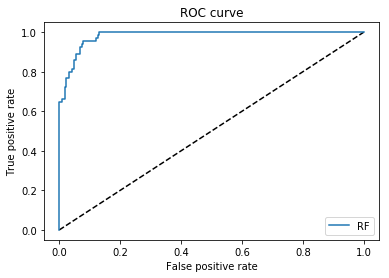

In [55]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Performance: Test

              precision    recall  f1-score   support

           0       0.87      0.94      0.91        88
           1       0.29      0.14      0.19        14

   micro avg       0.83      0.83      0.83       102
   macro avg       0.58      0.54      0.55       102
weighted avg       0.79      0.83      0.81       102

Confusion Matrix
[[83  5]
 [12  2]]


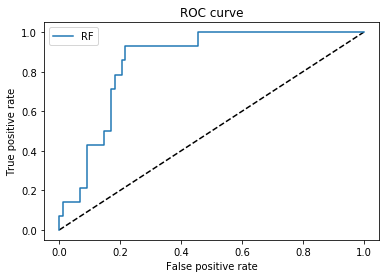

In [56]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()